<a href="https://colab.research.google.com/github/tnguyenqh/Corporate-branded-chart/blob/master/Fine_tuning_sentimental_analysis_(custom_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.28.0
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00


In [4]:
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-07-24 11:54:35--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  4.44MB/s    in 0.7s    

2023-07-24 11:54:37 (4.44 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [6]:
import pandas as pd
df_ = pd.read_csv("AirlineTweets.csv")

In [7]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [13]:
df = df_[['text','airline_sentiment']].copy()

In [14]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


<Axes: >

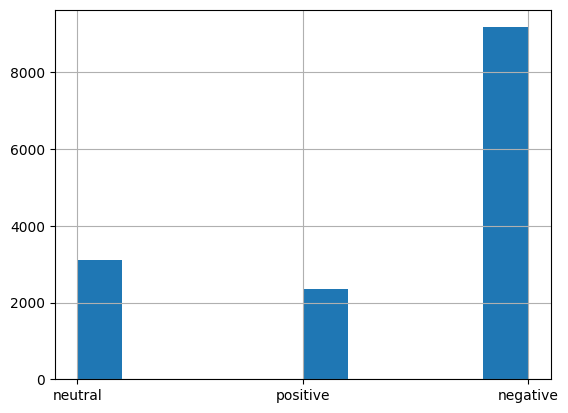

In [15]:
df['airline_sentiment'].hist()

In [18]:
target_map = {'positive':1,'negative':0,'neutral':2}
df['target'] = df['airline_sentiment'].map(target_map)

In [19]:
df2 = df[['text','target']]
df2.columns = ['sentence','label']
df2.to_csv('data.csv',index=None)

In [20]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [21]:
from datasets import load_dataset
raw_dataset = load_dataset('csv',data_files = 'data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f89bf98384da041e/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [24]:
split = raw_dataset['train'].train_test_split(test_size=0.3 ,seed=42)

In [25]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [ ]:
#if you have multiple files
#load_dataset('csv',data_files =['file1.csv','file2.csv'])

#if you already have a train-test split
#load_dataset('csv',data_files={'train':['train1.csv','train2.csv'],
#                                'test':['test1.csv','test2.csv']})

In [26]:
checkpoint= 'distilbert-base-cased'

In [27]:
from transformers import AutoTokenizer

In [28]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [31]:
def tokenizer_fn(batch):
  return tokenizer(batch['sentence'],truncation = True)

In [32]:
tokenized_datasets = split.map(tokenizer_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [33]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier

In [36]:
! pip install torchinfo

In [37]:
import torchinfo

In [38]:
from torchinfo import summary

In [39]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [40]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size =64
)

In [46]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions = np.argmax(logits,axis=-1)
  acc= np.mean(predictions == labels)
  f1 = f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}


In [48]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [49]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.178600,0.787246,0.824909,0.760689
2,0.139000,0.873141,0.827641,0.772716
3,0.102900,0.987340,0.830829,0.771963


TrainOutput(global_step=1923, training_loss=0.12255230634335236, metrics={'train_runtime': 200.9695, 'train_samples_per_second': 152.978, 'train_steps_per_second': 9.569, 'total_flos': 388376501242176.0, 'train_loss': 0.12255230634335236, 'epoch': 3.0})

In [50]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [51]:
from transformers import pipeline

In [52]:
savedmodel = pipeline('text-classification',model='training_dir/checkpoint-1282',device=0)

In [53]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [54]:
test_pred = savedmodel(split['test']['sentence'])

In [55]:
test_pred

[{'label': 'LABEL_1', 'score': 0.992668867111206},
 {'label': 'LABEL_1', 'score': 0.992591381072998},
 {'label': 'LABEL_0', 'score': 0.6947274208068848},
 {'label': 'LABEL_1', 'score': 0.9954977035522461},
 {'label': 'LABEL_2', 'score': 0.9943428039550781},
 {'label': 'LABEL_0', 'score': 0.9975456595420837},
 {'label': 'LABEL_2', 'score': 0.9992727637290955},
 {'label': 'LABEL_2', 'score': 0.9972565770149231},
 {'label': 'LABEL_1', 'score': 0.8290859460830688},
 {'label': 'LABEL_0', 'score': 0.9989823698997498},
 {'label': 'LABEL_0', 'score': 0.9982264637947083},
 {'label': 'LABEL_0', 'score': 0.9984583854675293},
 {'label': 'LABEL_1', 'score': 0.6493012309074402},
 {'label': 'LABEL_0', 'score': 0.9984847903251648},
 {'label': 'LABEL_2', 'score': 0.9989677667617798},
 {'label': 'LABEL_2', 'score': 0.9864575266838074},
 {'label': 'LABEL_0', 'score': 0.8986567258834839},
 {'label': 'LABEL_0', 'score': 0.9982861876487732},
 {'label': 'LABEL_0', 'score': 0.9986065030097961},
 {'label': 'LA

In [57]:
def get_label(d):
  return int(d['label'].split('_')[1])

In [58]:
test_pred = [get_label(d) for d in test_pred]

In [60]:
print("acc:", accuracy_score(split['test']['label'],test_pred))

acc: 0.8276411657559198


In [62]:
print("f1_score:", f1_score(split['test']['label'],test_pred,average='macro'))

f1_score: 0.7727162902178651


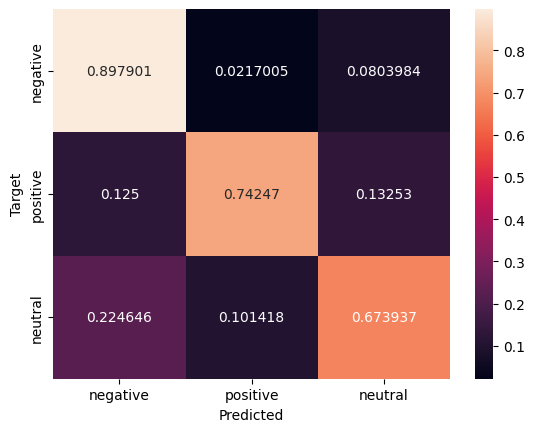

In [65]:
def plot(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm,index=classes,columns=classes)
  ax = sn.heatmap(df_cm,annot=True,fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm=confusion_matrix(split['test']['label'],test_pred,normalize='true')
plot(cm)